<a href="https://colab.research.google.com/github/InbumS/DreamscomeTrue/blob/main/ELMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

임베딩 벡터 => 단어를 벡터로 바꾸는 방법론

Word2Vec => CBOW, Skip-Gram

Glove

## ELMO
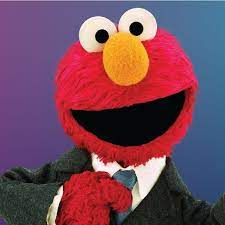

https://aclweb.org/anthology/N18-1202

ELMO is a function providing contextualized embedding

문장에 따른 다른 임베딩을 ELMO는 출력할 수 있다.


* 같은 표기의 단어라도 문맥에 따라서 다르게 워드 임베딩을 할 수 있으면 자연어 처리의 성능을 올릴 수 있을 것입니다. 

* 워드 임베딩 시 문맥을 고려해서 임베딩을 하겠다는 아이디어가 문맥을 반영한 워드 임베딩(Contextualized Word Embedding) 

*  ELMo는 양쪽 방향의 언어 모델을 둘 다 학습하여 활용한다고하여 이 언어 모델을 biLM(Bidirectional Language Model) = (biLSTM+ LM) 이라고 한다.

* 모든 레이어의 출력값 활용해 임베딩을 만든다. 논문에 따르면 상위 레이어일수록 문맥에 의한 벡터, 하의 레이어일수록 문법에 가까운 벡터 출력

* biLM의 워드 임베딩 방법은 CNN char embedding 을 사용한다, 문맥에 영향을 받지 않다. Glove를 써도됨.다른 워드 벡터임베딩 방식을 써도됨.
OOV(Out of voca..)에 강력

* using resdiual connection

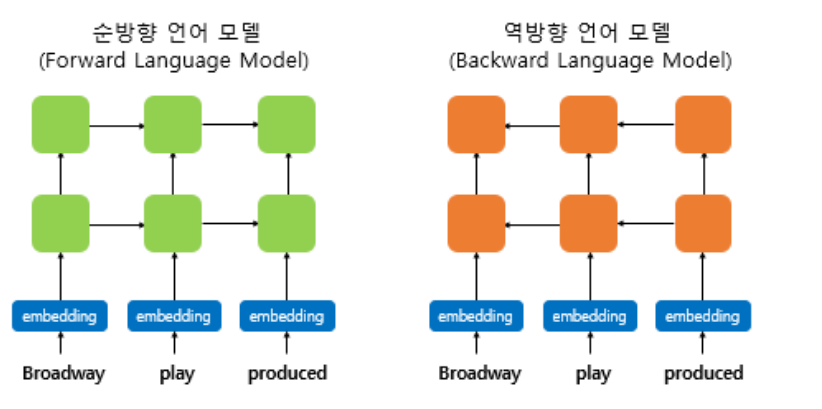



##  ELMo가 임베딩 벡터를 얻는 과정

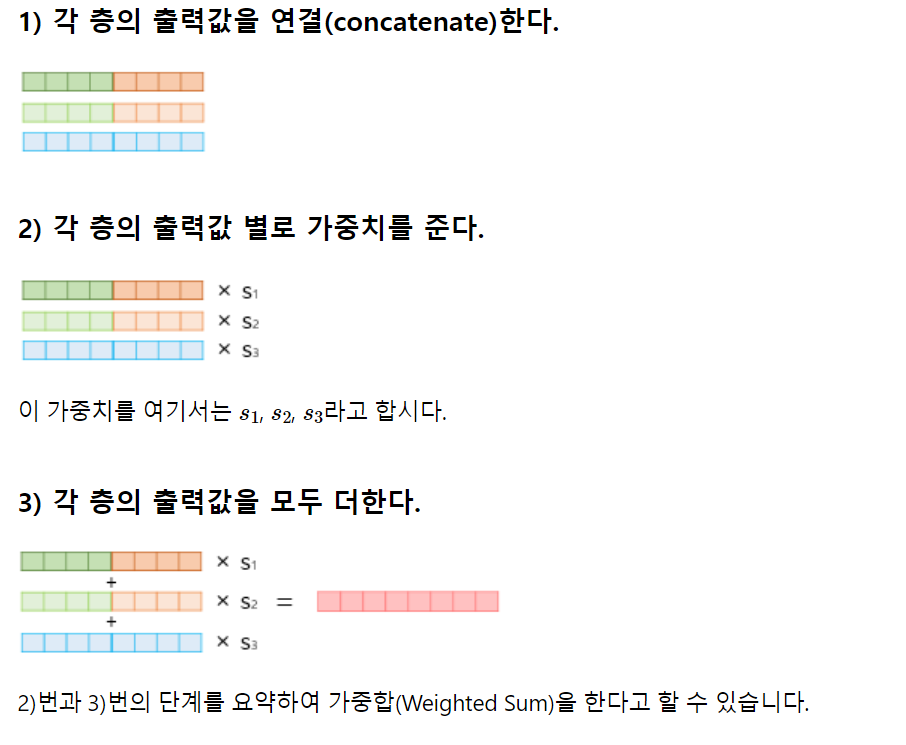

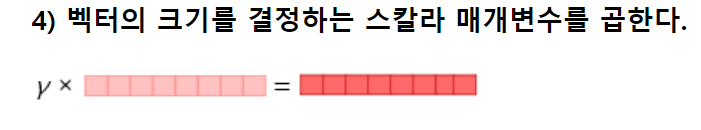

* 완성된 벡터를 ELMO표현 --> 다른 임베딩 기법들과 같이 활용할 수 있다

* 각각 LSTM 레이어는 음소 모델링시 앞뒤 컨텍스트를 고려하지 않고 독립적으로 보는 표현방식을 활용한다.
* 제일 상단의 LSTM output은 다음 토큰을 예측하는데 쓰인다.

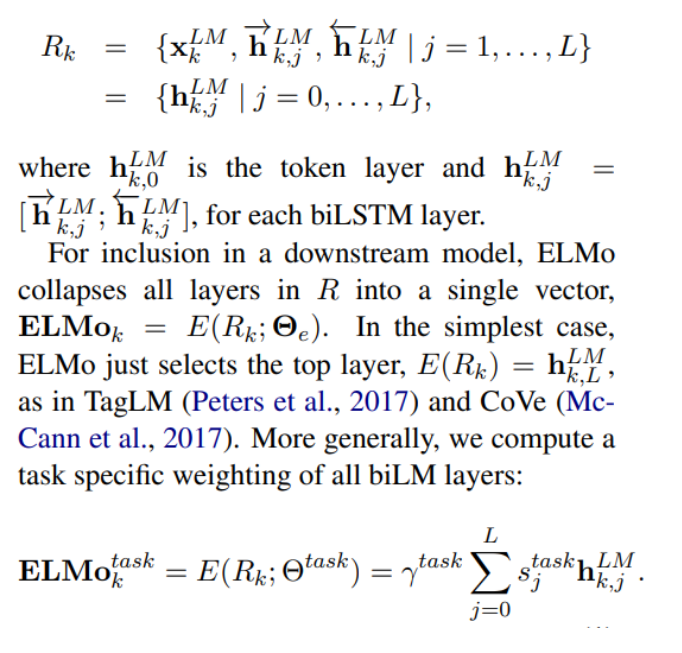

## evaluation study

Layer의 가중치 설정 대안

task에 맞게 가중치를 적용하는게 BEST > 가중치를 모두 같게 > 상단의 가중치 위주



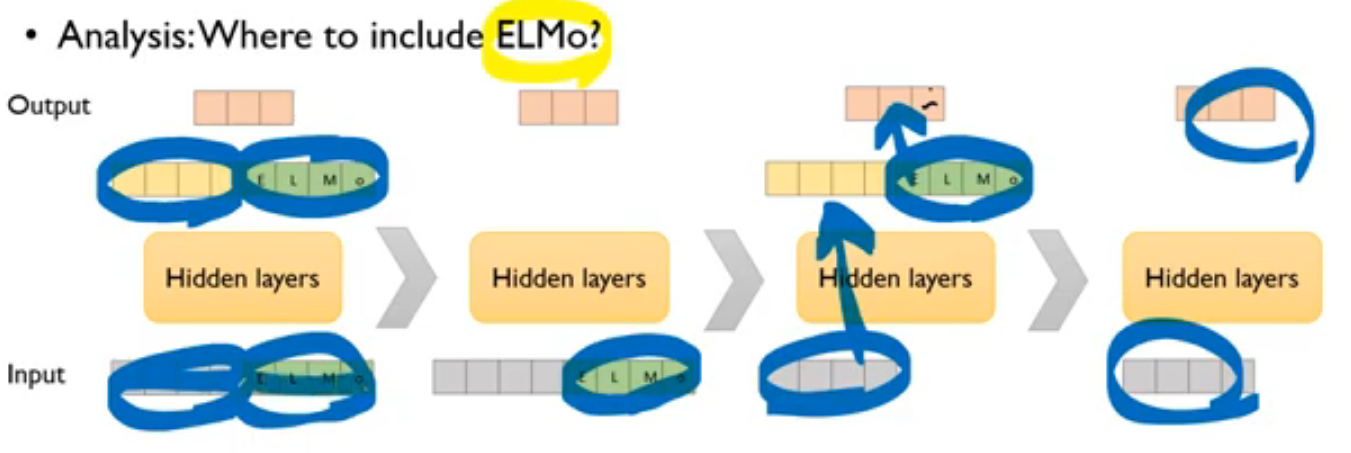



In [2]:
%tensorflow_version 2.x 

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
pip install tensorflow-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow_hub as hub
import tensorflow as tf
from keras import backend as K
import urllib.request
import pandas as pd
import numpy as np

In [ ]:
elmo= hub.Module("https://tfhub.dev/google/elmo/1", trainable=True)
# 텐서플로우 허브로부터 ELMo를 다운로드


In [9]:

sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

AttributeError: ignored

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv", filename="spam.csv")
data = pd.read_csv('spam.csv', encoding='latin-1')
data[:5]

In [ ]:
data['v1'] = data['v1'].replace(['ham','spam'],[0,1])
y_data = list(data['v1'])
X_data = list(data['v2'])

In [ ]:
print(len(X_data))
n_of_train = int(len(X_data) * 0.8)
n_of_test = int(len(X_data) - n_of_train)
print(n_of_train)
print(n_of_test)

In [ ]:
X_train = np.asarray(X_data[:n_of_train]) #X_data 데이터 중에서 앞의 4457개의 데이터만 저장
y_train = np.asarray(y_data[:n_of_train]) #y_data 데이터 중에서 앞의 4457개의 데이터만 저장
X_test = np.asarray(X_data[n_of_train:]) #X_data 데이터 중에서 뒤의 1115개의 데이터만 저장
y_test = np.asarray(y_data[n_of_train:]) #y_data 데이터 중에서 뒤의 1115개의 데이터만 저장

In [ ]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), as_dict=True, signature="default")["default"]
# 데이터의 이동이 케라스 → 텐서플로우 → 케라스가 되도록 하는 함수

In [ ]:
from keras.models import Model
from keras.layers import Dense, Lambda, Input

input_text = Input(shape=(1,), dtype=tf.string)
embedding_layer = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
hidden_layer = Dense(256, activation='relu')(embedding_layer)
output_layer = Dense(1, activation='sigmoid')(hidden_layer)
model = Model(inputs=[input_text], outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=1, batch_size=60)

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))